In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transform
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import utils

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

batch_size = 64

img_transform = transform.Compose([transform.ToTensor(), transform.Normalize((0.5,),(0.5,))]) 

train_set =  torchvision.datasets.ImageFolder('drive/MyDrive/datasets/dataset/train', img_transform)
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
print(train_set)

test_set =  torchvision.datasets.ImageFolder('drive/MyDrive/datasets/dataset/val', img_transform)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True, pin_memory=True)
print(test_set)

img, _ = train_set[0]
print("Image Shape:", img.shape)

cuda:0
Dataset ImageFolder
    Number of datapoints: 1370
    Root location: drive/MyDrive/datasets/dataset/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset ImageFolder
    Number of datapoints: 340
    Root location: drive/MyDrive/datasets/dataset/val
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Image Shape: torch.Size([3, 256, 256])


In [4]:
# convolucion 1
dim_after_conv1 = utils.size_output_layer(256, 4, 2, 1)
print(dim_after_conv1)

# convolucion 2
dim_after_conv2 = utils.size_output_layer(dim_after_conv1, 4, 2, 1)
print(dim_after_conv2)

128
64


In [9]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.conv1 = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU()
    )
    self.conv2 = nn.Sequential(
      nn.Conv2d(in_channels=64, out_channels=64*2, kernel_size=4, stride=2, padding=1),
      nn.BatchNorm2d(64*2),
      nn.ReLU()
    )
    self.fc = nn.Linear(in_features=64*2*64*64, out_features=10)

  def forward(self, image):
    self.out1 = F.relu(self.conv1(image))
    self.out2 = F.relu(self.conv2(self.out1))
    self.out3 = self.out2.view(self.out2.size(0), -1)
    z = self.fc(self.out3)
    return z

class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.fc    = nn.Linear(in_features=10,out_features=64*2*64*64)
    self.convTran1 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=2*2*64,out_channels=64, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.convTran2 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=2*64,out_channels=3, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(3),
        nn.ReLU()
    )
   
  def forward(self, latent, encoder):
    out = self.fc(latent)
    out = out.view(out.size(0), 64*2, 64, 64)
    out = F.relu(self.convTran1(torch.cat([out, encoder.out2], dim=1)))
    out = torch.tanh(self.convTran2(torch.cat([out, encoder.out1], dim=1)))
    return out


In [13]:
class Autoencoder(nn.Module):
   def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

   def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent, self.encoder)
        return  x_recon

In [14]:
def train(model, train_loader, Epochs, loss_fn):
    train_loss_avg = []
    for epoch in range(Epochs):
      train_loss_avg.append(0)
      num_batches = 0
    
      for image_batch, _ in tqdm(train_loader):
          image_batch = image_batch.to(device)
          image_batch_recon = model(image_batch)

          loss = loss_fn(image_batch_recon, image_batch)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          train_loss_avg[-1] += loss.item()
          num_batches += 1
          
      train_loss_avg[-1] /= num_batches
      print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, Epochs, train_loss_avg[-1]))
    return train_loss_avg

In [15]:

capacity = 64
latent_dims = 10
learning_rate = 0.001
autoencoder = Autoencoder()
autoencoder.to(device)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)

autoencoder.train()

loss_result = train(autoencoder,train_loader,10,loss)

100%|██████████| 22/22 [01:57<00:00,  5.34s/it]


Epoch [1 / 10] average reconstruction error: 0.337830


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Epoch [2 / 10] average reconstruction error: 0.247750


100%|██████████| 22/22 [00:23<00:00,  1.09s/it]


Epoch [3 / 10] average reconstruction error: 0.239781


100%|██████████| 22/22 [00:24<00:00,  1.09s/it]


Epoch [4 / 10] average reconstruction error: 0.238444


100%|██████████| 22/22 [00:24<00:00,  1.10s/it]


Epoch [5 / 10] average reconstruction error: 0.233594


100%|██████████| 22/22 [00:24<00:00,  1.10s/it]


Epoch [6 / 10] average reconstruction error: 0.231781


100%|██████████| 22/22 [00:24<00:00,  1.10s/it]


Epoch [7 / 10] average reconstruction error: 0.229755


100%|██████████| 22/22 [00:24<00:00,  1.10s/it]


Epoch [8 / 10] average reconstruction error: 0.230852


100%|██████████| 22/22 [00:24<00:00,  1.09s/it]


Epoch [9 / 10] average reconstruction error: 0.228471


100%|██████████| 22/22 [00:24<00:00,  1.09s/it]

Epoch [10 / 10] average reconstruction error: 0.226616


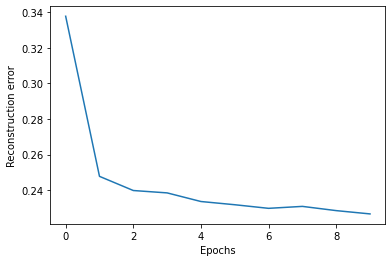

In [16]:
fig = plt.figure()
plt.plot(loss_result)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

In [ ]:
def Show(out, title = ''):
  print(title)
  out = out.permute(1,0,2,3)
  grilla = torchvision.utils.make_grid(out,10,5)
  plt.imshow(transforms.ToPILImage()(grilla), 'jet')
  plt.show()

def Show_Weight(out):
  grilla = torchvision.utils.make_grid(out)
  plt.imshow(transform.ToPILImage()(grilla), 'jet')
  plt.show()

In [18]:
autoencoder.eval()
tensor = torch.zeros(len(test_loader),10)

with torch.no_grad():
  image,label = iter(test_loader).next()

  image = image.to(device)
  label = label.to(device)

  z = autoencoder.encoder(image)
  z = z.to(device)

  decodificado = autoencoder.decoder(z, autoencoder.encoder)
  decodificado = decodificado.to('cpu')

******************  **************************
Número de canales: 3
Dimensiones: 256 x 256


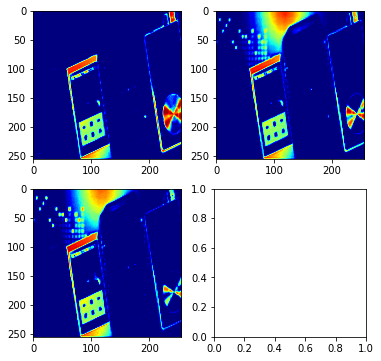

In [22]:
utils.show_img(decodificado[0], color_map='jet')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


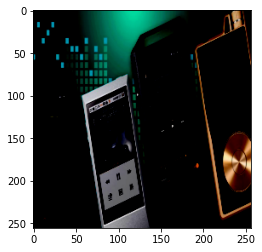

In [48]:
plt.imshow(image[0].detach().to('cpu').permute(1,2,0))
plt.show()

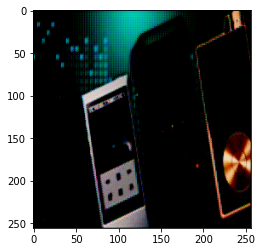

In [49]:
plt.imshow(decodificado[0].detach().permute(1,2,0))
plt.show()